In [1]:
# importing dependencies
import mysql.connector
from mysql.connector import connect
from getpass import getpass
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
# connecting to SQL
db = connect(host = "localhost",
            user = "root",
            passwd = getpass("Enter password: "),
             database = "sakila")

Enter password: ········


In [3]:
# cursor is an instance used to execute sql statements on python
cursor = db.cursor(buffered = True)
cursor.execute("SHOW DATABASES")

In [4]:
# cursor is an instance used to execute sql statements on python
databases = cursor.fetchall()
print(databases)

[('bank',), ('bank_demo',), ('house_price_regression',), ('information_schema',), ('mysql',), ('performance_schema',), ('sakila',), ('sys',)]


#### Ex.1 Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. 

In [5]:
 query = "select r.rental_id, f.film_id, f.title, f.release_year, f.rental_duration, f.rental_rate,f.length, f.replacement_cost, f.rating, r.customer_id, convert(r.rental_date, date) as rental_date,convert(r.return_date,date) as return_date, p.amount,  convert(p.payment_date,date) as payment_date, c.name as category, l.name as language from rental as r join inventory as i on i.inventory_id = r.inventory_id join film as f on f.film_id = i.film_id left join payment as p on p.rental_id = r.rental_id  join film_category as fc on fc.film_id = f.film_id join category as c on c.category_id = fc.category_id join language as l on l.language_id= f.language_id order by r.rental_id asc;"

In [6]:
cursor.execute(query)

In [7]:
records = cursor.fetchall

#### Ex.2 Read the data into a Pandas dataframe. 

In [8]:
df = pd.read_sql_query(query,db) # changing sql data into pandas dataframe

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


#### Ex.3: Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables. 

In [9]:
df.head()

,rental_id,film_id,title,release_year,rental_duration,rental_rate,length,replacement_cost,rating,customer_id,rental_date,return_date,amount,payment_date,category,language
0,1,80,BLANKET BEVERLY,2006,7,2.99,148,21.99,G,130,2005-05-24,2005-05-26,2.99,2005-05-24,Family,English
1,2,333,FREAKY POCUS,2006,7,2.99,126,16.99,R,459,2005-05-24,2005-05-28,2.99,2005-05-24,Music,English
2,3,373,GRADUATE LORD,2006,7,2.99,156,14.99,G,408,2005-05-24,2005-06-01,3.99,2005-05-24,Children,English
3,4,535,LOVE SUICIDES,2006,6,0.99,181,21.99,R,333,2005-05-24,2005-06-03,4.99,2005-05-24,Horror,English
4,5,450,IDOLS SNATCHERS,2006,5,2.99,84,29.99,NC-17,222,2005-05-24,2005-06-02,6.99,2005-05-24,Children,English


In [10]:
df.info() # checking data types of variables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16055 entries, 0 to 16054
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_id         16055 non-null  int64  
 1   film_id           16055 non-null  int64  
 2   title             16055 non-null  object 
 3   release_year      16055 non-null  int64  
 4   rental_duration   16055 non-null  int64  
 5   rental_rate       16055 non-null  float64
 6   length            16055 non-null  int64  
 7   replacement_cost  16055 non-null  float64
 8   rating            16055 non-null  object 
 9   customer_id       16055 non-null  int64  
 10  rental_date       16055 non-null  object 
 11  return_date       15872 non-null  object 
 12  amount            16044 non-null  float64
 13  payment_date      16044 non-null  object 
 14  category          16055 non-null  object 
 15  language          16055 non-null  object 
dtypes: float64(3), int64(6), object(7)
memor

As clear from info that few of variables such as release_year, rental_date, return_date, payment_date misleading datatype. we can convert their type to date. 

In [11]:
import datetime as dt 

df[['rental_date','return_date', 'payment_date']] = df[['rental_date','return_date', 'payment_date']].apply(pd.to_datetime)

df.info() # checking whether datatype of dates columns has been changed or not.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16055 entries, 0 to 16054
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rental_id         16055 non-null  int64         
 1   film_id           16055 non-null  int64         
 2   title             16055 non-null  object        
 3   release_year      16055 non-null  int64         
 4   rental_duration   16055 non-null  int64         
 5   rental_rate       16055 non-null  float64       
 6   length            16055 non-null  int64         
 7   replacement_cost  16055 non-null  float64       
 8   rating            16055 non-null  object        
 9   customer_id       16055 non-null  int64         
 10  rental_date       16055 non-null  datetime64[ns]
 11  return_date       15872 non-null  datetime64[ns]
 12  amount            16044 non-null  float64       
 13  payment_date      16044 non-null  datetime64[ns]
 14  category          1605

In [12]:
df.shape

(16055, 16)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16055 entries, 0 to 16054
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rental_id         16055 non-null  int64         
 1   film_id           16055 non-null  int64         
 2   title             16055 non-null  object        
 3   release_year      16055 non-null  int64         
 4   rental_duration   16055 non-null  int64         
 5   rental_rate       16055 non-null  float64       
 6   length            16055 non-null  int64         
 7   replacement_cost  16055 non-null  float64       
 8   rating            16055 non-null  object        
 9   customer_id       16055 non-null  int64         
 10  rental_date       16055 non-null  datetime64[ns]
 11  return_date       15872 non-null  datetime64[ns]
 12  amount            16044 non-null  float64       
 13  payment_date      16044 non-null  datetime64[ns]
 14  category          1605

#### Ex. 4: Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [14]:
# creating boolean based on rental_date
df['june_rentals'] = (df['rental_date'] >= '2005-06-01') & (df['rental_date'] < '2005-07-01')
df.june_rentals.value_counts()

False    13744
True      2311
Name: june_rentals, dtype: int64

In [15]:
# changing boolean column into binary as we can't apply model on Boolean data.
df['june_rentals'] = [1 if b==False else 0 for b in df.june_rentals]
df.june_rentals.value_counts()

1    13744
0     2311
Name: june_rentals, dtype: int64

our data is highly imbalance, True(0) class represents rentals made in month of june while the false not for august. True class is just 14% of whole dataset. 

In [16]:
#checking and dealing with nan
df.isna().sum()

rental_id             0
film_id               0
title                 0
release_year          0
rental_duration       0
rental_rate           0
length                0
replacement_cost      0
rating                0
customer_id           0
rental_date           0
return_date         183
amount               11
payment_date         11
category              0
language              0
june_rentals          0
dtype: int64

In [17]:
# columns relating to user_id's and dates does not make much sense for analysis 
#esp when we dummify them it creates too many columns which raises problem of multicollinearity in dataset, 
#so we drop them here before removing nans.

df.drop(['rental_id','film_id','release_year','customer_id','return_date','payment_date','language'], axis = 1, inplace = True)


In [18]:
#removing nan from data using KNNImputer
# as we have to apply imputer only on 
num_data = df.select_dtypes(include = np.number) 
cat_data = df.select_dtypes(np.object)

from sklearn.impute import KNNImputer
knn = KNNImputer(n_neighbors=2) # choosing 2 nearst neighbours is completely random. 
new_num_data=knn.fit_transform(num_data)
num_data=pd.DataFrame(new_num_data,columns=num_data.columns)
df=pd.merge(cat_data,num_data,left_index=True,right_index=True)

C:\Users\s_sad\AppData\Local\Temp\ipykernel_7100\2680828957.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_data = df.select_dtypes(np.object)


KNN imputer has been used instead, as it does not reduce variance of dataset unlike mean. 

In [19]:
df.columns # in the new dataset, we have not added columns relating to dates

Index(['title', 'rating', 'category', 'rental_duration', 'rental_rate',
       'length', 'replacement_cost', 'amount', 'june_rentals'],
      dtype='object')

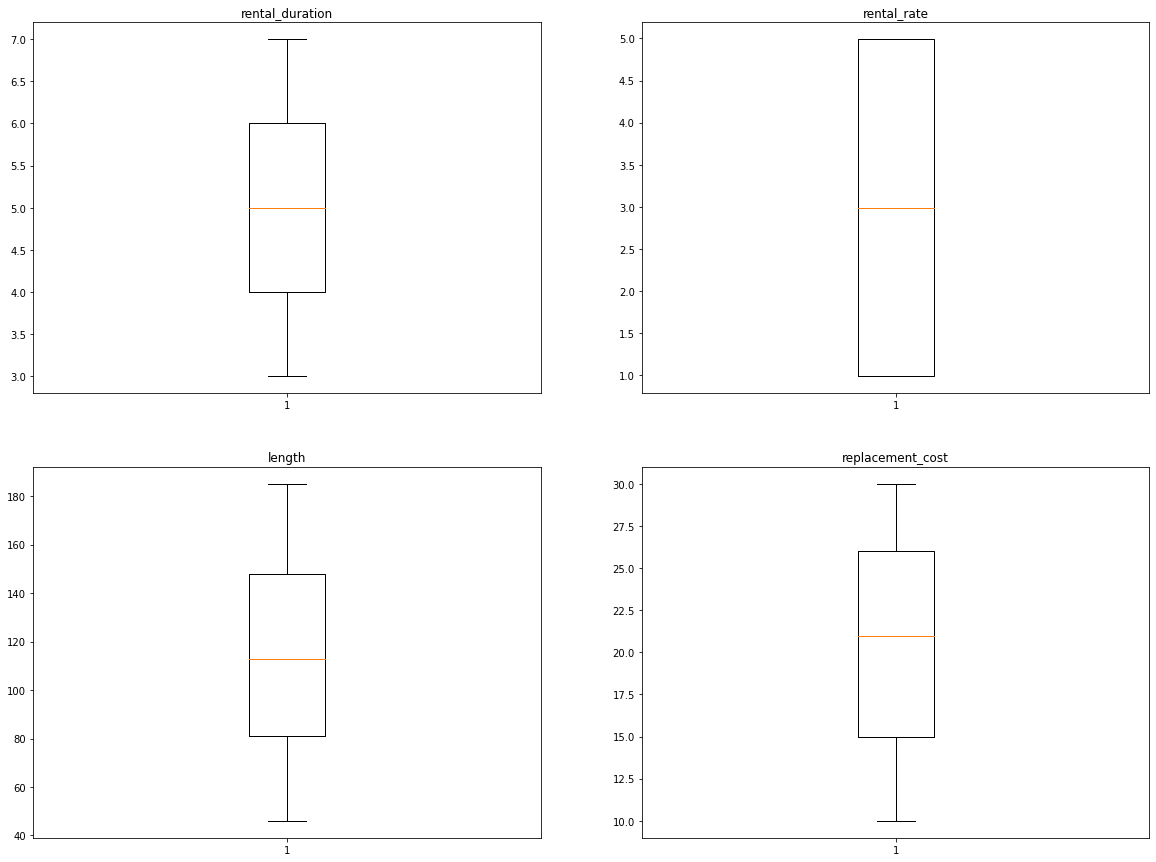

In [20]:
#checking outliers in numerical data
fig, axs = plt.subplots(2,2, figsize=(20,15))

axs[0, 0].boxplot(df['rental_duration'])
axs[0, 1].boxplot(df['rental_rate'])
axs[1, 0].boxplot(df['length'])
axs[1, 1].boxplot(df['replacement_cost'])


axs[0, 0].title.set_text('rental_duration')
axs[0, 1].title.set_text('rental_rate')
axs[1, 0].title.set_text('length')
axs[1, 1].title.set_text('replacement_cost')

plt.show()

There are no outliers in data. So we let it as it is.

In [21]:
df.describe()

,rental_duration,rental_rate,length,replacement_cost,amount,june_rentals
count,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000,16055.000000
mean,4.936219,2.941292,114.951230,20.215973,4.199156,0.856057
std,1.401486,1.649904,40.095773,6.079721,2.363645,0.351043
min,3.000000,0.990000,46.000000,9.990000,0.000000,0.000000
25%,4.000000,0.990000,81.000000,14.990000,2.990000,1.000000
50%,5.000000,2.990000,113.000000,20.990000,3.990000,1.000000
75%,6.000000,4.990000,148.000000,25.990000,4.990000,1.000000
max,7.000000,4.990000,185.000000,29.990000,11.990000,1.000000


### Random Forest 

We will first try to apply Random Forest, if it performs better then we will stick with it. 

In [22]:
# separate target variable Y from features X
# defining dataset

features_list = ['title', 'rental_duration','rental_rate','replacement_cost','length', 'rating','amount', 'category']

X = df.loc[:, features_list]
y = df.loc[:, "june_rentals"]

# Train Test Split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)

from sklearn.preprocessing import OneHotEncoder

# By default, OneHotEncoder errors if it sees unknown categories in the test data
# we will overwrite this behavior by specifying handle_unknown='ignore'
# also OneHotEncoder by default outputs scipy sparse matrices, which are more efficient but cumbersome
# we disable that with sparse=False

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(X_train)
# apply one-hot encoding to both training and test set

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)


In [23]:
#cols = X_train.columns

In [24]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

classifier = RandomForestClassifier(n_estimators=100, random_state =0)
classifier.fit(X_train, y_train)

print("Train Score : {}".format(classifier.score(X_train, y_train)))
print('Test Score : {}'.format(classifier.score(X_test, y_test)))

pred_train =classifier.predict(X_train)
pred_test = classifier.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, classifier.predict(X_train))
cm_test = confusion_matrix(y_test, classifier.predict(X_test))


Train Score : 0.8773707698029007
Test Score : 0.827514625401019
              precision    recall  f1-score   support

         0.0       0.83      0.20      0.33      1571
         1.0       0.88      0.99      0.93      9185

    accuracy                           0.88     10756
   macro avg       0.85      0.60      0.63     10756
weighted avg       0.87      0.88      0.84     10756

              precision    recall  f1-score   support

         0.0       0.09      0.03      0.04       740
         1.0       0.86      0.96      0.91      4559

    accuracy                           0.83      5299
   macro avg       0.47      0.49      0.47      5299
weighted avg       0.75      0.83      0.78      5299



1. Model is predicting very well, accuracy is more than 80% for both train and test set. But it is slightly underfitting.
2. The classification report shows that model can't distinguish b/w two classes very well. High accuracy score is due to high class 1. But for train data the precision is good for both 1 and 0 class as opposite to test data.
3. Due to highly imbalance data model is unable to predict minority class(0) which is rentals made in month of June.

We will now check more simpler model for it.

### Logistic Regression

In [25]:
# separate target variable Y from features X
features_list = ['title', 'rental_duration','rental_rate', 'replacement_cost', 'rating','amount', 'category','length']
X = df.loc[:, features_list]
y = df.loc[:, "june_rentals"]


# splitting dataset into train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33, random_state = 0)

# Encoding categorical features and standardizing numeric features
## First let's import libraries
## StandardScaler to scale data (i.e apply Z-score)
## OneHotEncoder to encode categorical variables

numeric_features =[1,2,3,5,7]# Choose which column index we are going to scale
categorical_features = [0,4,6]

categorical_transformer = OneHotEncoder()
numeric_transformer = StandardScaler()

feature_encoder = ColumnTransformer (
  transformers = [              
      ("catel", categorical_transformer, categorical_features), # to categorical this object applies OneHotEncoder
       ("num", numeric_transformer, numeric_features),# to numerical we apply the Standard Scaler
  ])
# applying transfomer 
X_train = feature_encoder.fit_transform(X_train)
X_test = feature_encoder.transform(X_test)

# Model application
model= LogisticRegression()
model.fit(X_train, y_train)

print("Train Score : {}".format(model.score(X_train, y_train)))
print('Test Score : {}'.format(model.score(X_test, y_test)))

# classification report
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test))
print(classification_report(y_train, pred_train))

Train Score : 0.8539419858683526
Test Score : 0.8603510096244574
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       740
         1.0       0.86      1.00      0.92      4559

    accuracy                           0.86      5299
   macro avg       0.43      0.50      0.46      5299
weighted avg       0.74      0.86      0.80      5299

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1571
         1.0       0.85      1.00      0.92      9185

    accuracy                           0.85     10756
   macro avg       0.43      0.50      0.46     10756
weighted avg       0.73      0.85      0.79     10756



C:\Users\s_sad\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\s_sad\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\s_sad\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision

Here again, we have same conclusion as for random forest.
1. Overall, model is predicting very well, train and test set both have and accuracy of 85%.
2. The classification report shows that model is only predicting class 1 which is rentals not made in month of June. 
3. Due to highly imbalance data model is unable to predict minority class(0) which is rentals made in month of June.

### Random Undersampling (Logistic Regression) - Model Improvement 

In [26]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# summarize class distribution
print(Counter(y))
# define oversampling strategy
under = RandomUnderSampler()
# fit and apply the transform
X_train_under,y_train_under = under.fit_resample(X_train,y_train)
# summarize class distribution
print(Counter(y_train_under))

# apply model
model = LogisticRegression()
model.fit(X_train_under, y_train_under)

# predictions on train and test set
pred_train_under = model.predict(X_train_under)
pred_test_under = model.predict(X_test)

# printing model accuracy
print("accuracy on train set:",accuracy_score(y_train_under,pred_train_under))
print("accuracy on test set:",accuracy_score(y_test,pred_test_under))

print("f1 score on train set:",f1_score(y_train_under,pred_train_under))
print("f1 score on test set:",f1_score(y_test,pred_test_under))


# print classification report
print(classification_report(y_train_under, pred_train_under))
print(classification_report(y_test, pred_test_under))

Counter({1.0: 13744, 0.0: 2311})
Counter({0.0: 1571, 1.0: 1571})
accuracy on train set: 0.6779121578612349
accuracy on test set: 0.4483864880166069
f1 score on train set: 0.6783216783216782
f1 score on test set: 0.585213566056478
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68      1571
         1.0       0.68      0.68      0.68      1571

    accuracy                           0.68      3142
   macro avg       0.68      0.68      0.68      3142
weighted avg       0.68      0.68      0.68      3142

              precision    recall  f1-score   support

         0.0       0.11      0.42      0.18       740
         1.0       0.83      0.45      0.59      4559

    accuracy                           0.45      5299
   macro avg       0.47      0.44      0.38      5299
weighted avg       0.73      0.45      0.53      5299



Model is overfitting.

### Random Oversampling (Logistic Regression) - Model Improvement 

In [27]:


# summarize class distribution
print(Counter(y))
# define oversampling strategy
over = RandomOverSampler()
# fit and apply the transform
X_train_over,y_train_over = over.fit_resample(X_train,y_train)
# summarize class distribution
print(Counter(y_train_over))

# apply model
model = LogisticRegression()
model.fit(X_train_over, y_train_over)

# predictions on train and test set
pred_train_over = model.predict(X_train_over)
pred_test_over = model.predict(X_test)

# printing model accuracy
print("accuracy on train set:",accuracy_score(y_train_over,pred_train_over))
print("accuracy on test set:",accuracy_score(y_test,pred_test_over))

print("f1 score on train set:",f1_score(y_train_over,pred_train_over))
print("f1 score on test set:",f1_score(y_test,pred_test_over))

# print classification report
print(classification_report(y_train_over, pred_train_over))
print(classification_report(y_test, pred_test_over))


Counter({1.0: 13744, 0.0: 2311})
Counter({0.0: 9185, 1.0: 9185})
accuracy on train set: 0.634512792596625
accuracy on test set: 0.4949990564257407
f1 score on train set: 0.6102403343782654
f1 score on test set: 0.6441489361702128
              precision    recall  f1-score   support

         0.0       0.62      0.70      0.66      9185
         1.0       0.65      0.57      0.61      9185

    accuracy                           0.63     18370
   macro avg       0.64      0.63      0.63     18370
weighted avg       0.64      0.63      0.63     18370

              precision    recall  f1-score   support

         0.0       0.09      0.27      0.13       740
         1.0       0.82      0.53      0.64      4559

    accuracy                           0.49      5299
   macro avg       0.45      0.40      0.39      5299
weighted avg       0.72      0.49      0.57      5299



C:\Users\s_sad\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


For Train Set:
Model is overfitting obvious from accuracy score.
1. Out of all the rentals that the model predicted for month of june, 62% were actually made.(precision)
2. Out of all the rentals in june that actually occured, the model predicted this outcome correctly for 69% of those rentals (recall).
3. F1 Score: This value is calculated as:
F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
Since this value is closer to 1, it tells us that the model does a good job of predicting whether or not rentals will be made.

For Test Set:
1. Out of all the rentals that the model predicted, only 0.09% were actually made in june.(precision)
2. Out of all the rentals that were actuallly done, the model predicted this outcome correctly for 30% of those rentals.
3. Since this value is  0.63, it tells us that the model is doing a good job of predicting whether or not rentals will be made.

So we can conclude that, after applying random oversampling model is performing better than before but still needs further improvement, as it is not performing very well for test set. 

The previous model with rentals made in August has achieved better scores after applying over and under sampling techniques but here overfitting is introduced. But this model is more closer to reality in the sense that data is less imbalance, and more observation are real and not generated randomly by machine.  
